In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

In [2]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
test_image = mpimg.imread('test_images/test_image.jpg')

In [3]:
#Initializing variables

imgpoints = [] # 2D points in image plane
objpoints = [] # 3D points in real world space

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinate

corner_images = []

undistorted_images = []

# Choose a Sobel kernel size
ksize = 9 # larger odd number to smooth gradient measurements
img_size = (test_image.shape[0], test_image.shape[1])
src = np.float32([[180, img_size[0]], [575, 460], [705, 460], [1150, img_size[0]]])
dst = np.float32([[280, img_size[0]], [280, 0], [960, 0], [960, img_size[0]]])

In [4]:
def find_draw_corners(img, nx=9, ny=6):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        corner_images.append(img)
    else:
        corner_images.append(img)
        
def undistort_img(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 1) Convert to grayscale
    
    # Take the derivative in x orient = 'x'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max        
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def color_threshold(img, thresh=(0, 255)):
    
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    r_channel = img[:,:,0]
    color_binary = np.zeros_like(r_channel)
    color_binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    return color_binary

def combined(gradex, channel_binary):
    combined = np.zeros_like(channel_binary)
    combined[(gradex == 1) | (channel_binary == 1)] = 1
    return combined

def perspective_tranform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return binary_warped, M, Minv

In [5]:
def detect_lane(binary_warped):
    # Create an output image to draw on and  visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 # binary_wraped shape - (720, 1280)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)  # 640

    leftx_base = np.argmax(histogram[:midpoint])  # 346 Index

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint  # 956 Index

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)  # 720/9 = 80
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):  # [0, 1, 2, .... , 8]
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height  # 720 - (1)*80 = 640
        win_y_high = binary_warped.shape[0] - window*window_height  # 720 - 0 = 720
        win_xleft_low = leftx_current - margin  # 346 - 100 = 246 Index
        win_xleft_high = leftx_current + margin  # 346 + 100 = 446 Index
        win_xright_low = rightx_current - margin  # 956 - 100 = 856 Index
        win_xright_high = rightx_current + margin  # 956 + 100 = 1056 Index
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)  #(246, 640), (446, 720)
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:  # 1754 > 50
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    
    return ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx

In [6]:
def curvature_offset(ploty, lefty, righty, leftx, rightx, w, h):
    y_eval = np.max(ploty)
    lane_width_pix = w * 0.57
    ym_per_pix = 23/h # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width_pix # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvrad = np.mean([left_curverad, right_curverad])
    
    image_centre = lane_width_pix * xm_per_pix / 2
    
    vehicle_centre = np.mean([left_fit_cr, right_fit_cr])
    
    vehicle_offset = abs(image_centre - vehicle_centre)
    
    return curvrad, vehicle_offset

def draw_lane(binary_warped, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Distance from centre: {:.2f} m'.format(vehicle_offset), (100,80), fontFace = 16,\
                    fontScale = 2, color=(255,255,255), thickness = 4)
        
    cv2.putText(result, 'Radius of Curvature {} m'.format(int(curverad)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 4)
    
    return result

In [7]:
#To Calibrate Camera
for file in os.listdir("camera_cal/"):
    img = cv2.imread("camera_cal/"+file)
    find_draw_corners(img)

In [8]:
# Apply each of the thresholding functions
def get_result_image(image):
    undist = undistort_img(image)
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    channel_binary = color_threshold(image, thresh=(195, 255))
    combined_binary = combined(gradx, channel_binary)
    binary_warped, M, Minv = perspective_tranform(combined_binary, src, dst)
    ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx = detect_lane(binary_warped)
    curverad, vehicle_offset = curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
    result_img = draw_lane(binary_warped, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)
    return result_img

1442.31096192 m 0.905364592834 m


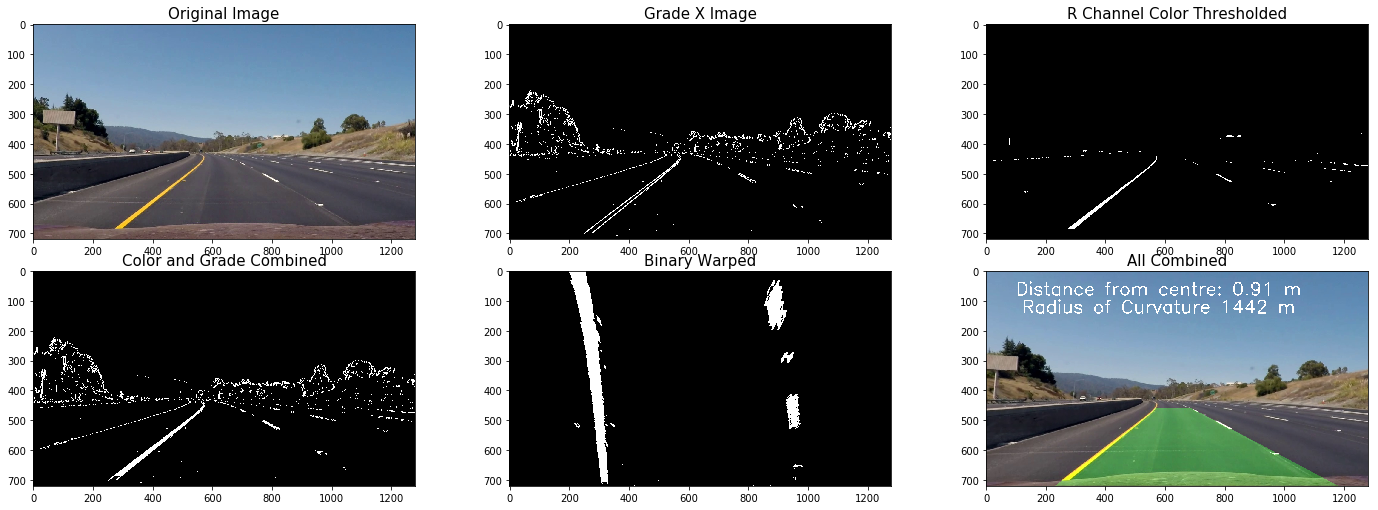

In [9]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 7))
f.tight_layout()
undist = undistort_img(test_image)
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
channel_binary = color_threshold(test_image, thresh=(195, 255))
combined_binary = combined(gradx, channel_binary)
binary_warped, M, Minv = perspective_tranform(combined_binary, src, dst)
# final_img = detect_lane(binary_warped)
ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx = detect_lane(binary_warped)
curverad, vehicle_offset = curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
print (curverad,"m",vehicle_offset,"m")
result_img = draw_lane(binary_warped, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)

ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=15)

ax2.imshow(gradx, cmap='gray')
ax2.set_title('Grade X Image', fontsize=15)

ax3.imshow(channel_binary, cmap='gray')
ax3.set_title('R Channel Color Thresholded', fontsize=15)

ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Color and Grade Combined', fontsize=15)

ax5.imshow(binary_warped, cmap='gray')
ax5.set_title('Binary Warped', fontsize=15)

ax6.imshow(result_img, cmap='gray')
ax6.set_title('All Combined', fontsize=15)

plt.show()

(1280,)


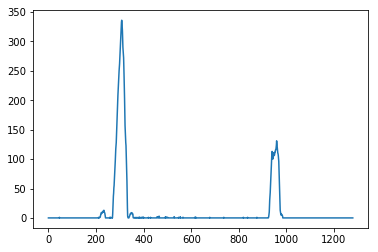

In [10]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
print(histogram.shape)
plt.plot(histogram)
plt.show()

In [11]:
def process_image(image):
    result = get_result_image(image)
    return result

In [12]:
project_output_video = 'processed_project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(project_output_video, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [49:23<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

Wall time: 49min 26s
